In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import torch
from torch import nn
from torch import optim
import os
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def carregar_dadosv2(train_data, test_data, test_size=0.2, random_state=42):
    # Load data from CSV file
    scaler = StandardScaler()

    train_data = pd.read_csv(train_data)
    val_data = pd.read_csv(test_data)

    # Split data into features (X) and targets (y) ("hysteresis")
    X = train_data.drop(['hysteresis', 'joule'], axis=1)
    y = train_data[['hysteresis', 'joule']]

    # Perform train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)

    X_test = val_data.drop(['hysteresis', 'joule'], axis=1)
    y_test = val_data[['hysteresis', 'joule']]

    X_train = scaler.fit_transform(X_train.values)
    X_val = scaler.transform(X_val.values)
    X_test = scaler.transform(X_test.values)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


    return X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor

In [4]:
import matplotlib.pyplot as plt
import torch

def plot_comparacao(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    plt.figure(figsize=(8, 6))

    plt.scatter(y_true, y_pred, color='blue', alpha=0.5)

    max_val = max(y_true.max(), y_pred.max())
    plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2, label='Linha de Referência')

    plt.xlabel('Valores previstos')
    plt.ylabel('valores Reais')
    plt.title('Comparação entre Valores Reais e Valores Previstos')
    plt.legend()


    plt.show()


import matplotlib.pyplot as plt

In [5]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(RegressionModel, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(input_dim if _ == 0 else hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [6]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 11.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [7]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00


In [8]:
from torch import tensor
from torchmetrics.regression import MeanAbsolutePercentageError
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
import optuna


def load_model(filename, model_class, input_size, output_size):
    print("Carregando modelo...")
    checkpoint = torch.load(filename)

    model = model_class(input_size, output_size)

    model.load_state_dict(checkpoint['state_dict'])

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    optimizer.load_state_dict(checkpoint['optimizer'])

    return model, optimizer

def save_model(state,filename="Saved_Model.pth"):
  print("salvando modelo...")
  torch.save(state,filename)
def create_train_model(input_dim, output_dim, X_train, y_train, X_val, y_val):
    def train_model(trial):

        hidden_dim = trial.suggest_int('hidden_dim', 16, 64)
        num_layers = trial.suggest_int('num_layers', 10, 40)
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 2e-4, log=True)
        batch_size = trial.suggest_int('batch_size', 512, 512)

        model = RegressionModel(input_dim, hidden_dim, output_dim, num_layers).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        X_train_device = X_train.to(device)
        y_train_device = y_train.to(device)
        X_val_device = X_val.to(device)
        y_val_device = y_val.to(device)

        model.train()
        for epoch in range(150):
            permutation = torch.randperm(X_train.size()[0]).to(device)
            for i in range(0, X_train.size()[0], batch_size):
                optimizer.zero_grad()
                indices = permutation[i:i + batch_size]
                batch_x, batch_y = X_train[indices], y_train[indices]

                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = mean_squared_error(y_val.cpu().numpy(), val_outputs.cpu().numpy())
            plot_comparacao(y_val, val_outputs)


        return val_loss

    return train_model

def evaluate(model,val_set,val_target):
    criterion = nn.MSELoss()
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_set)
        val_loss = criterion(val_outputs, val_target)
        print(f'Val_Loss: {val_loss}')


def test(model,data):
  model.eval()
  criterion_MSE = nn.MSELoss()
  criterion_MAE = nn.L1Loss()
  criterion_MAPE = MeanAbsolutePercentageError()
  with torch.no_grad():
      predicted = model(data[0]).to(device)
      test_loss_MSE = criterion_MSE(predicted, data[1].to(device))
      test_loss_MAE = criterion_MAE(predicted, data[1].to(device))
      test_loss_MAPE = criterion_MAPE(predicted, data[1].to(device))
      print(f'MSE Test Loss: {test_loss_MSE.item():.4f}')
      print(f'MAE Test Loss: {test_loss_MAE.item():.4f}')
      print(f'MAPE Test Loss: {test_loss_MAPE.item():.4f}')
  return predicted

In [9]:
folder_path = '/content/drive/MyDrive/FederatedLearning-main/Data/IPMSM_datasets/dataset_for_iron_losses_of_IPMSMs/V'
os.chdir(folder_path)

X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor = carregar_dadosv2('dados_de_treino.csv','dados_de_teste.csv')


In [10]:
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [11]:
histeresis_train_tensor = [pair[0].item() for pair in y_train_tensor]
histeresis_train_tensor = torch.tensor(histeresis_train_tensor, dtype=torch.float32).to(device)
histeresis_train_tensor = histeresis_train_tensor.unsqueeze(1)

joule_train_tensor = [pair[1].item() for pair in y_train_tensor]
joule_train_tensor = torch.tensor(joule_train_tensor, dtype=torch.float32).to(device)
joule_train_tensor = joule_train_tensor.unsqueeze(1)

histeresis_val_tensor = [pair[0].item() for pair in y_val_tensor]
histeresis_val_tensor = torch.tensor(histeresis_val_tensor, dtype=torch.float32).to(device)
histeresis_val_tensor = histeresis_val_tensor.unsqueeze(1)

joule_val_tensor = [pair[1].item() for pair in y_val_tensor]
joule_val_tensor = torch.tensor(joule_val_tensor, dtype=torch.float32).to(device)
joule_val_tensor = joule_val_tensor.unsqueeze(1)

histeresis_test_tensor = [pair[0].item() for pair in y_test_tensor]
histeresis_test_tensor = torch.tensor(histeresis_test_tensor, dtype=torch.float32).to(device)
histeresis_test_tensor = histeresis_test_tensor.unsqueeze(1)

joule_test_tensor = [pair[1].item() for pair in y_test_tensor]
joule_test_tensor = torch.tensor(joule_test_tensor, dtype=torch.float32).to(device)
joule_test_tensor = joule_test_tensor.unsqueeze(1)

[I 2024-06-30 22:22:05,477] A new study created in memory with name: no-name-f76cb232-08e0-4ef1-a7df-e1b85fcd3a66


6


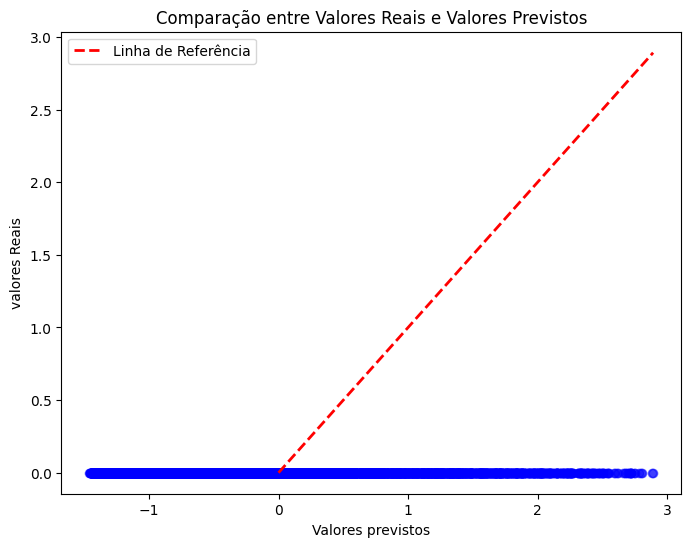

[I 2024-06-30 22:25:03,847] Trial 0 finished with value: 0.974245011806488 and parameters: {'hidden_dim': 61, 'num_layers': 36, 'learning_rate': 0.00012504515197513723, 'batch_size': 512}. Best is trial 0 with value: 0.974245011806488.


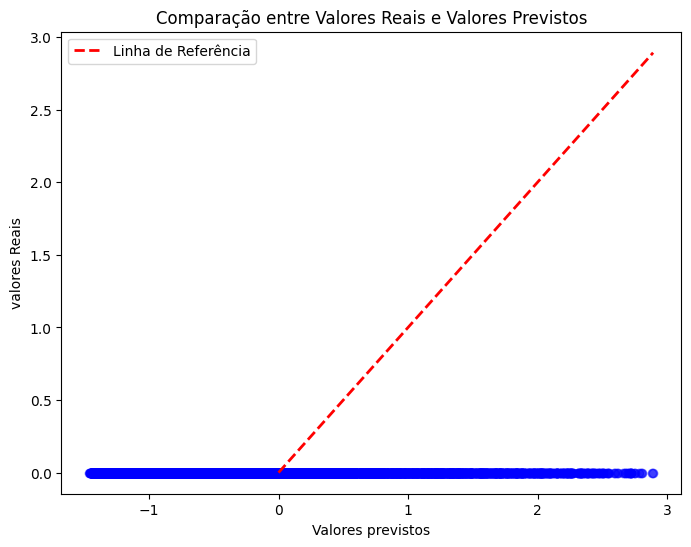

[I 2024-06-30 22:26:22,261] Trial 1 finished with value: 0.9742099046707153 and parameters: {'hidden_dim': 32, 'num_layers': 32, 'learning_rate': 0.00017102115832675474, 'batch_size': 512}. Best is trial 1 with value: 0.9742099046707153.


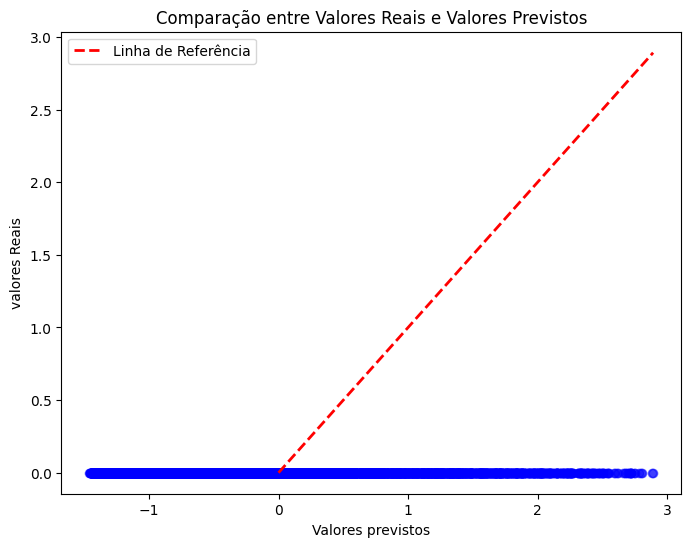

[I 2024-06-30 22:27:59,726] Trial 2 finished with value: 0.9742483496665955 and parameters: {'hidden_dim': 34, 'num_layers': 35, 'learning_rate': 0.00012155627401133271, 'batch_size': 512}. Best is trial 1 with value: 0.9742099046707153.


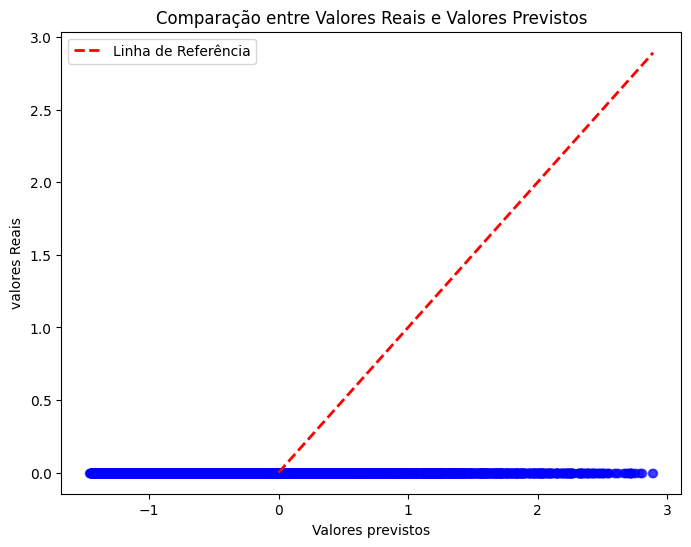

[I 2024-06-30 22:30:13,410] Trial 3 finished with value: 0.9742080569267273 and parameters: {'hidden_dim': 56, 'num_layers': 35, 'learning_rate': 0.00013899699304736592, 'batch_size': 512}. Best is trial 3 with value: 0.9742080569267273.


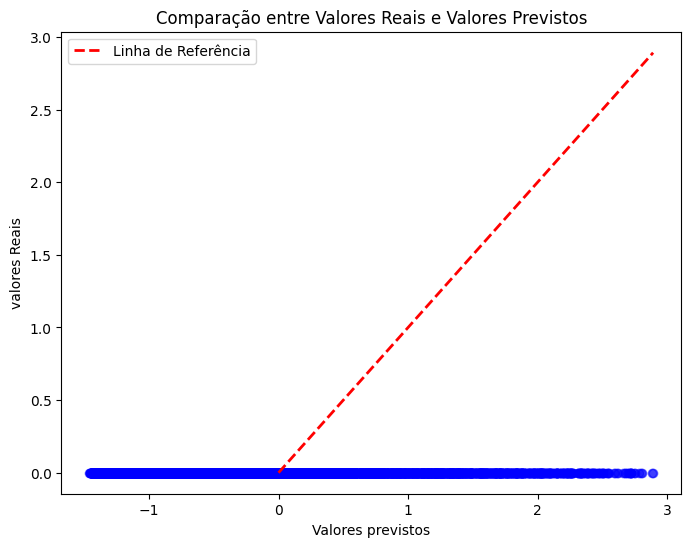

[I 2024-06-30 22:32:05,002] Trial 4 finished with value: 0.9742383360862732 and parameters: {'hidden_dim': 46, 'num_layers': 34, 'learning_rate': 0.0001362111449598707, 'batch_size': 512}. Best is trial 3 with value: 0.9742080569267273.


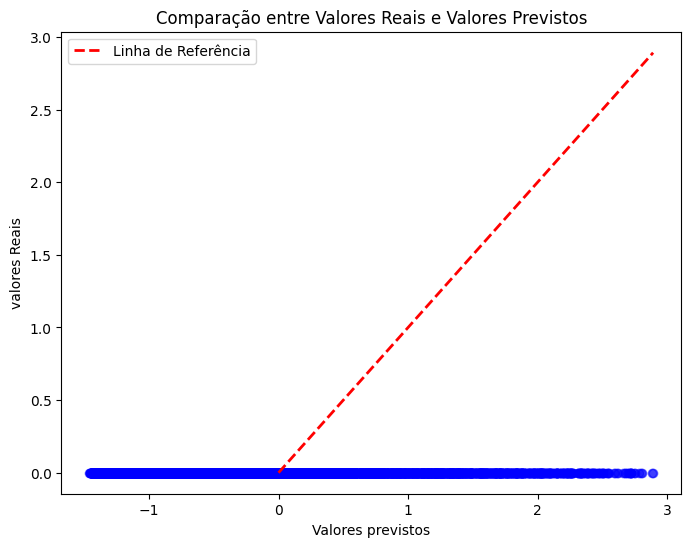

[I 2024-06-30 22:34:01,871] Trial 5 finished with value: 0.9742410778999329 and parameters: {'hidden_dim': 61, 'num_layers': 25, 'learning_rate': 0.0001904649083027308, 'batch_size': 512}. Best is trial 3 with value: 0.9742080569267273.


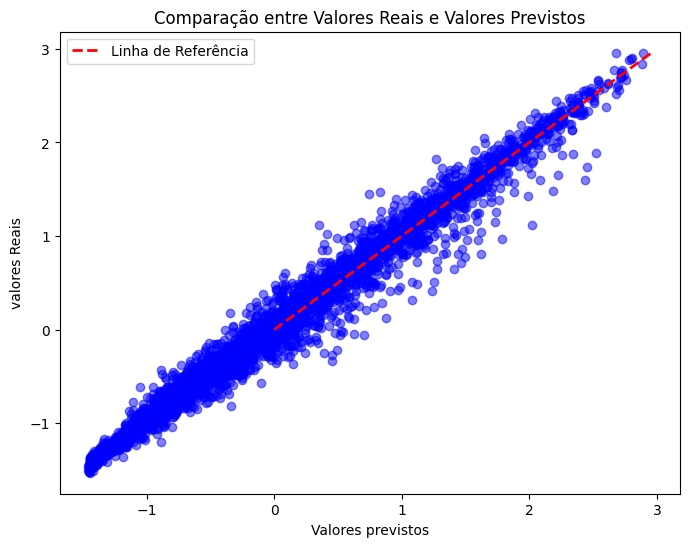

[I 2024-06-30 22:34:52,851] Trial 6 finished with value: 0.019211726263165474 and parameters: {'hidden_dim': 48, 'num_layers': 14, 'learning_rate': 0.00017501931996106619, 'batch_size': 512}. Best is trial 6 with value: 0.019211726263165474.


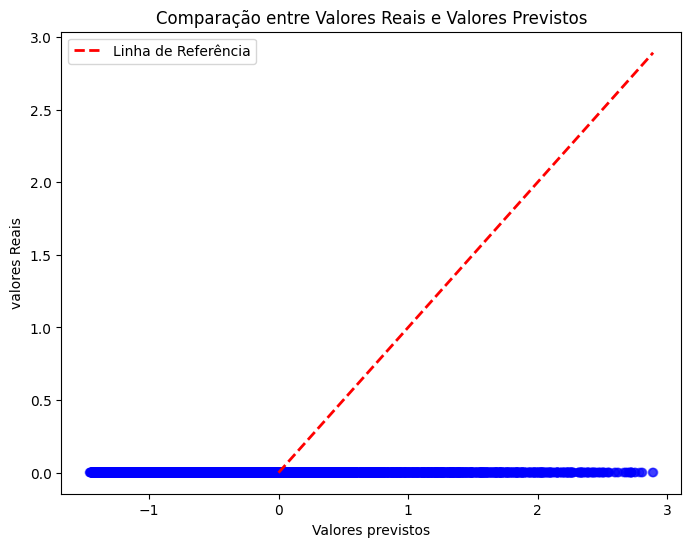

[I 2024-06-30 22:36:31,621] Trial 7 finished with value: 0.9743141531944275 and parameters: {'hidden_dim': 39, 'num_layers': 32, 'learning_rate': 0.00010445210437064805, 'batch_size': 512}. Best is trial 6 with value: 0.019211726263165474.


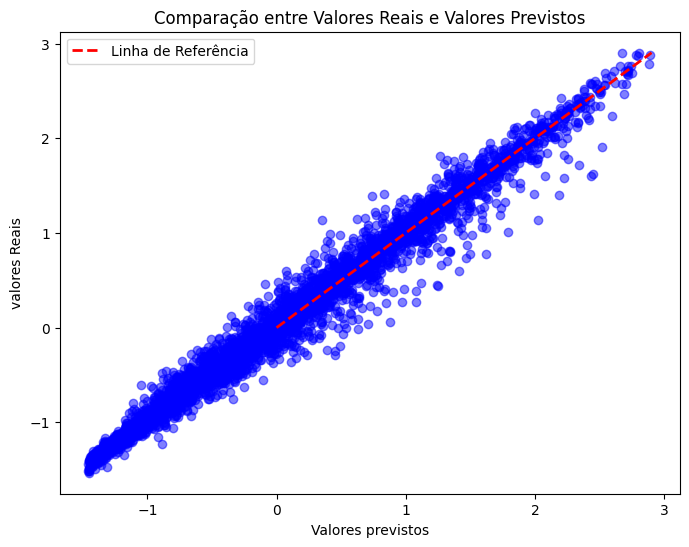

[I 2024-06-30 22:37:07,973] Trial 8 finished with value: 0.019695308059453964 and parameters: {'hidden_dim': 32, 'num_layers': 12, 'learning_rate': 0.00016341166181929934, 'batch_size': 512}. Best is trial 6 with value: 0.019211726263165474.


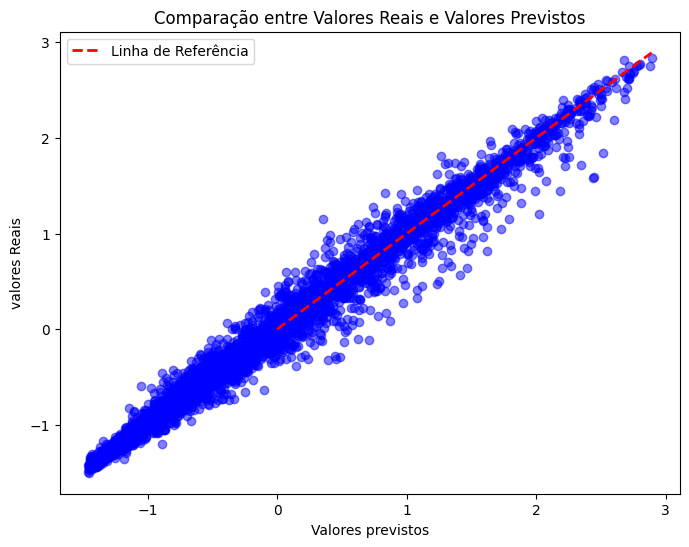

[I 2024-06-30 22:37:48,699] Trial 9 finished with value: 0.019951052963733673 and parameters: {'hidden_dim': 29, 'num_layers': 13, 'learning_rate': 0.0001788504806076438, 'batch_size': 512}. Best is trial 6 with value: 0.019211726263165474.


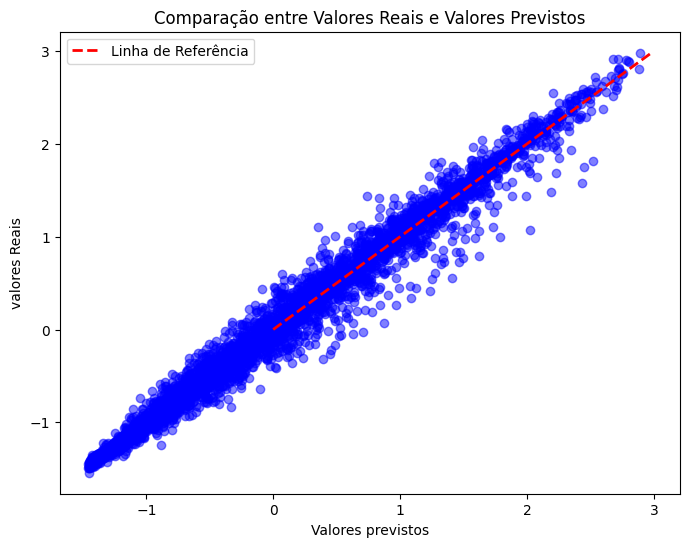

[I 2024-06-30 22:38:53,340] Trial 10 finished with value: 0.01933562196791172 and parameters: {'hidden_dim': 48, 'num_layers': 19, 'learning_rate': 0.00015742459213756416, 'batch_size': 512}. Best is trial 6 with value: 0.019211726263165474.


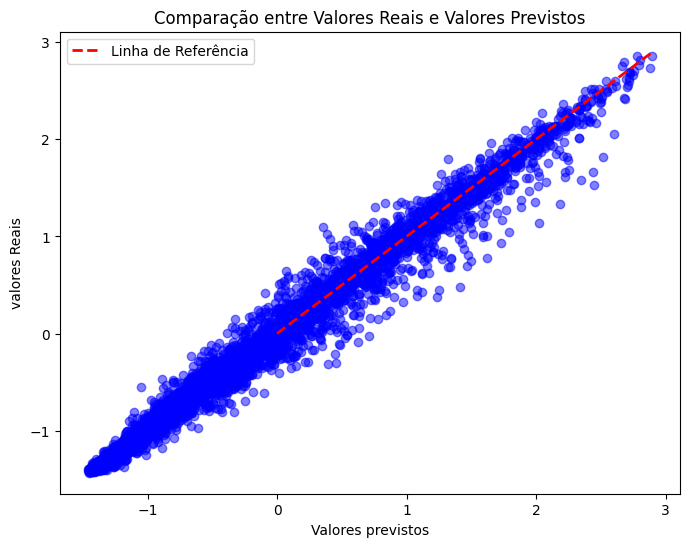

[I 2024-06-30 22:39:40,095] Trial 11 finished with value: 0.021974187344312668 and parameters: {'hidden_dim': 17, 'num_layers': 19, 'learning_rate': 0.00015390116423343343, 'batch_size': 512}. Best is trial 6 with value: 0.019211726263165474.


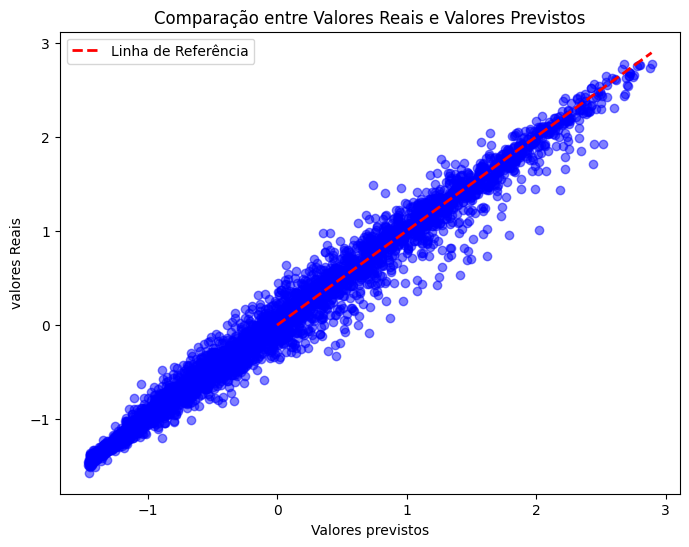

[I 2024-06-30 22:40:55,843] Trial 12 finished with value: 0.018984220921993256 and parameters: {'hidden_dim': 51, 'num_layers': 19, 'learning_rate': 0.00019782710342225134, 'batch_size': 512}. Best is trial 12 with value: 0.018984220921993256.


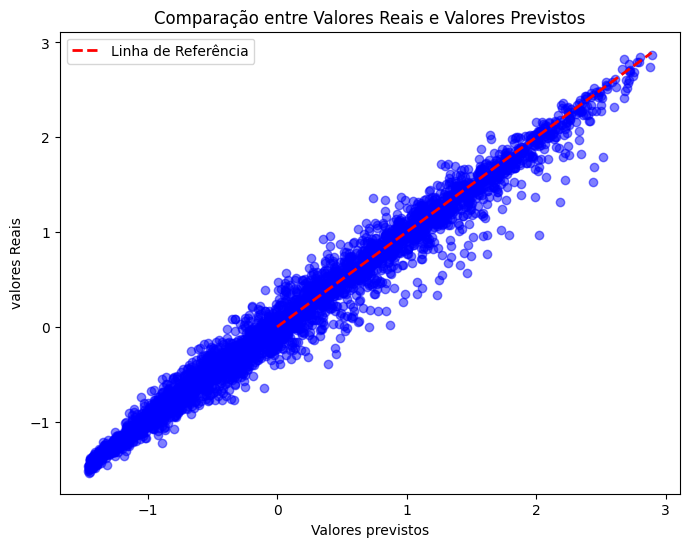

[I 2024-06-30 22:42:06,421] Trial 13 finished with value: 0.019094066694378853 and parameters: {'hidden_dim': 52, 'num_layers': 18, 'learning_rate': 0.00019501878167908, 'batch_size': 512}. Best is trial 12 with value: 0.018984220921993256.


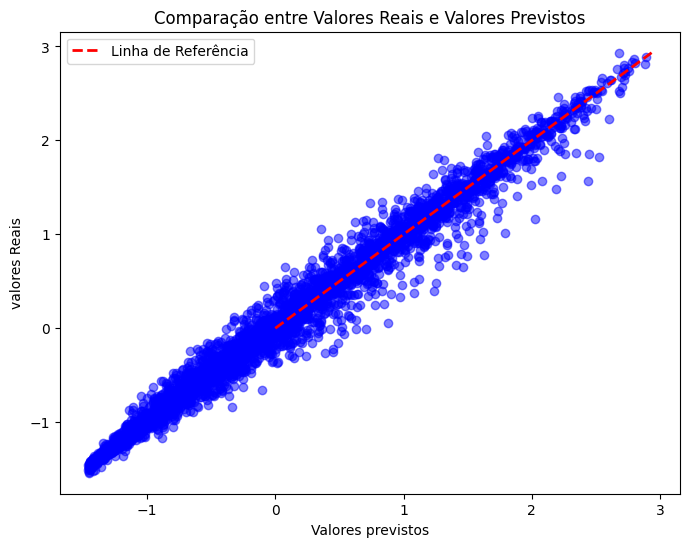

[I 2024-06-30 22:43:37,365] Trial 14 finished with value: 0.018647119402885437 and parameters: {'hidden_dim': 53, 'num_layers': 22, 'learning_rate': 0.00019838119862149463, 'batch_size': 512}. Best is trial 14 with value: 0.018647119402885437.


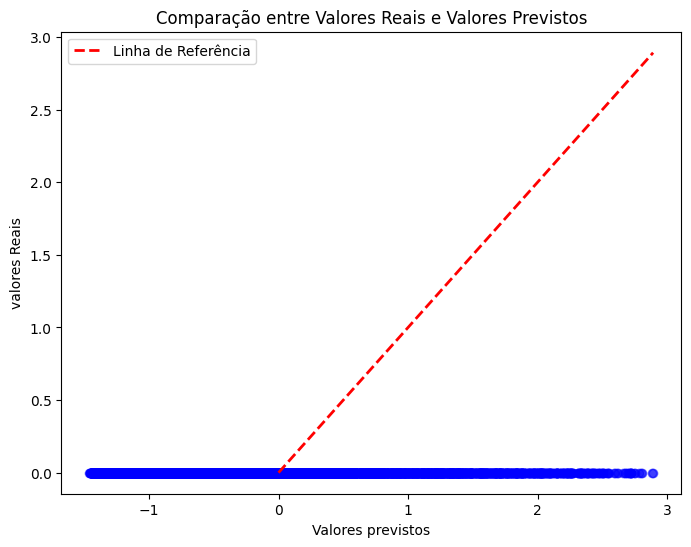

[I 2024-06-30 22:45:16,740] Trial 15 finished with value: 0.9742172956466675 and parameters: {'hidden_dim': 55, 'num_layers': 25, 'learning_rate': 0.00019391347385714963, 'batch_size': 512}. Best is trial 14 with value: 0.018647119402885437.


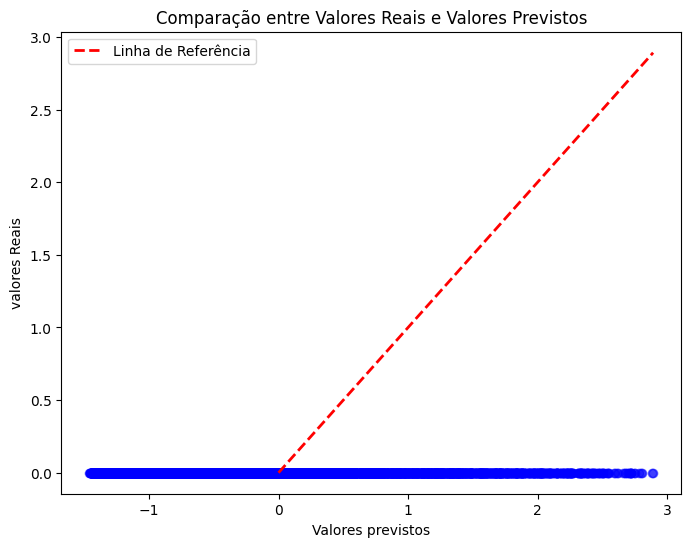

[I 2024-06-30 22:46:49,657] Trial 16 finished with value: 0.9742581248283386 and parameters: {'hidden_dim': 43, 'num_layers': 28, 'learning_rate': 0.0001998857142980262, 'batch_size': 512}. Best is trial 14 with value: 0.018647119402885437.


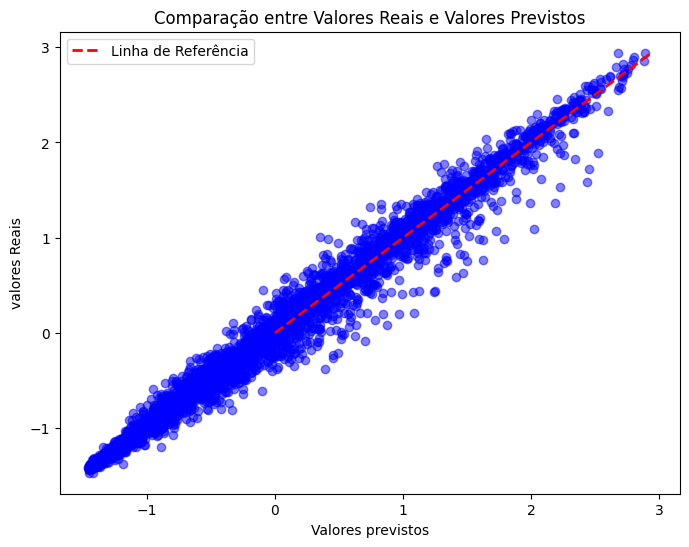

[I 2024-06-30 22:48:27,724] Trial 17 finished with value: 0.019119519740343094 and parameters: {'hidden_dim': 64, 'num_layers': 22, 'learning_rate': 0.0001501873532221173, 'batch_size': 512}. Best is trial 14 with value: 0.018647119402885437.


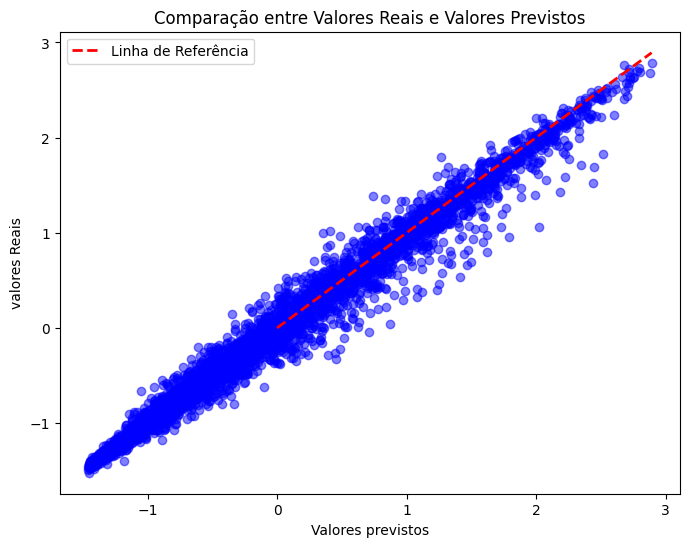

[I 2024-06-30 22:49:35,716] Trial 18 finished with value: 0.01976417377591133 and parameters: {'hidden_dim': 55, 'num_layers': 16, 'learning_rate': 0.0001808406310170979, 'batch_size': 512}. Best is trial 14 with value: 0.018647119402885437.


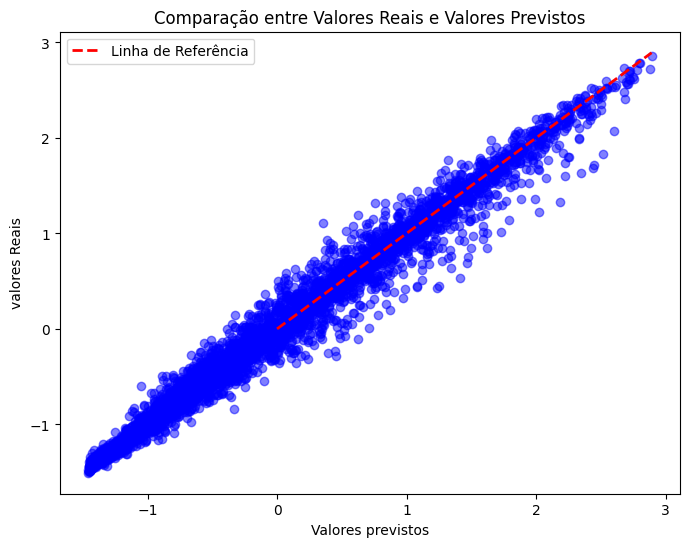

[I 2024-06-30 22:50:32,050] Trial 19 finished with value: 0.020946038886904716 and parameters: {'hidden_dim': 23, 'num_layers': 23, 'learning_rate': 0.00010584193532004494, 'batch_size': 512}. Best is trial 14 with value: 0.018647119402885437.


In [12]:
input_size = X_train_tensor.shape[1]
print(input_size)

study1 = optuna.create_study(direction='minimize')
train_model = create_train_model(input_size,1,X_train_tensor, histeresis_train_tensor,X_val_tensor,histeresis_val_tensor)
study1.optimize(train_model, n_trials=20)

trial = study1.best_trial

In [13]:
best_model_h = trial.params

best_model = RegressionModel(X_train_tensor.shape[1], best_model_h['hidden_dim'], 1, best_model_h['num_layers']).to(device)

optimizer = optim.Adam(best_model.parameters(), lr=best_model_h['learning_rate'])

for name, param in best_model.named_parameters():
    print(f"{name}: {param.size()}")

print(best_model)

network.0.weight: torch.Size([53, 6])
network.0.bias: torch.Size([53])
network.2.weight: torch.Size([53, 53])
network.2.bias: torch.Size([53])
network.4.weight: torch.Size([53, 53])
network.4.bias: torch.Size([53])
network.6.weight: torch.Size([53, 53])
network.6.bias: torch.Size([53])
network.8.weight: torch.Size([53, 53])
network.8.bias: torch.Size([53])
network.10.weight: torch.Size([53, 53])
network.10.bias: torch.Size([53])
network.12.weight: torch.Size([53, 53])
network.12.bias: torch.Size([53])
network.14.weight: torch.Size([53, 53])
network.14.bias: torch.Size([53])
network.16.weight: torch.Size([53, 53])
network.16.bias: torch.Size([53])
network.18.weight: torch.Size([53, 53])
network.18.bias: torch.Size([53])
network.20.weight: torch.Size([53, 53])
network.20.bias: torch.Size([53])
network.22.weight: torch.Size([53, 53])
network.22.bias: torch.Size([53])
network.24.weight: torch.Size([53, 53])
network.24.bias: torch.Size([53])
network.26.weight: torch.Size([53, 53])
network.2

In [14]:
def fine_tune(params,model,num_epochs,optimizer,train_set,target,val_set,val_target):
  criterion = nn.MSELoss()
  model.train()
  for epoch in range(num_epochs):
      permutation = torch.randperm(train_set.size()[0]).to(device)
      for i in range(0, train_set.size()[0], params['batch_size']):
          optimizer.zero_grad()
          indices = permutation[i:i + params['batch_size']]
          batch_x, batch_y = train_set[indices], target[indices]

          outputs = model(batch_x)
          loss = criterion(outputs, batch_y)
          loss.backward()
          optimizer.step()

  model.eval()
  with torch.no_grad():
      val_outputs = model(val_set)
      val_loss = mean_squared_error(val_target.cpu().numpy(), val_outputs.cpu().numpy())

fine_tune(best_model_h,best_model,5000,optimizer,X_train_tensor,histeresis_train_tensor,X_val_tensor,histeresis_val_tensor)
previstos_h = test(best_model.to(device), [X_test_tensor.to(device), histeresis_test_tensor.to(device)])
print(previstos_h)

MSE Test Loss: 0.0278
MAE Test Loss: 0.0954
MAPE Test Loss: 0.6426
tensor([[ 0.4431],
        [ 0.1860],
        [ 1.1131],
        ...,
        [ 1.2202],
        [-0.0152],
        [ 2.0915]])


In [15]:
print('Best trial:')
trial = study1.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

Best trial:
  Value: 0.018647119402885437
  Params: 
    hidden_dim: 53
    num_layers: 22
    learning_rate: 0.00019838119862149463
    batch_size: 512


[I 2024-06-30 23:41:57,302] A new study created in memory with name: no-name-c2e19a37-b4a4-4df4-9a83-ad9607278eab


6


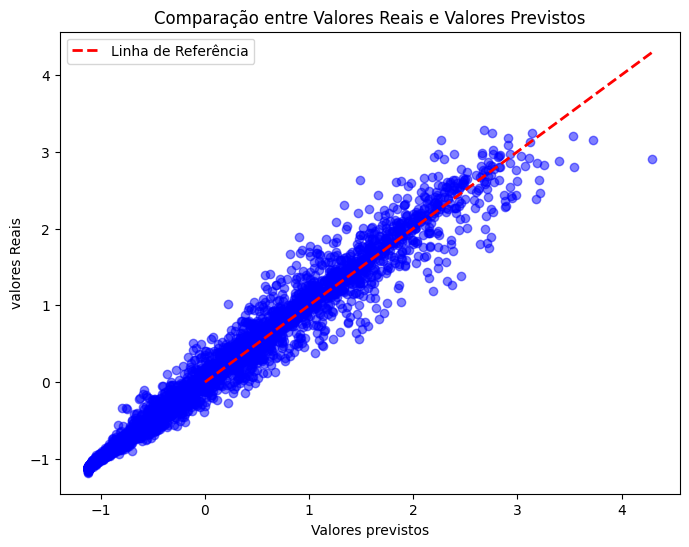

[I 2024-06-30 23:42:55,172] Trial 0 finished with value: 0.02866625413298607 and parameters: {'hidden_dim': 60, 'num_layers': 12, 'learning_rate': 0.0001923658497136864, 'batch_size': 512}. Best is trial 0 with value: 0.02866625413298607.


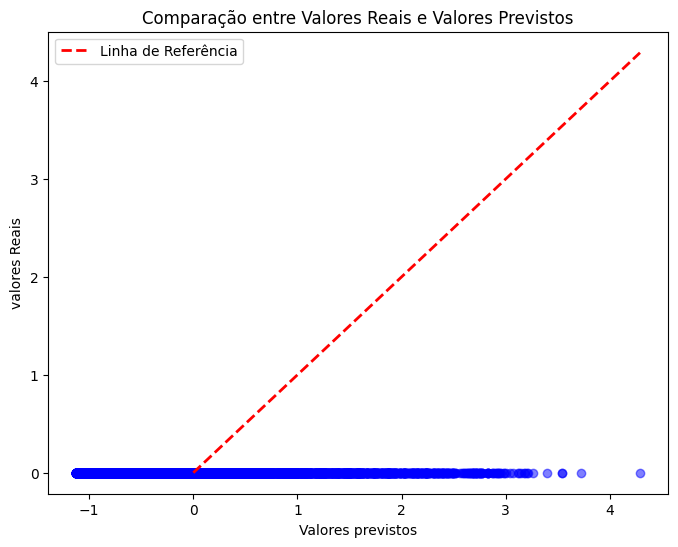

[I 2024-06-30 23:45:09,971] Trial 1 finished with value: 0.9915667176246643 and parameters: {'hidden_dim': 46, 'num_layers': 40, 'learning_rate': 0.0001373429063650778, 'batch_size': 512}. Best is trial 0 with value: 0.02866625413298607.


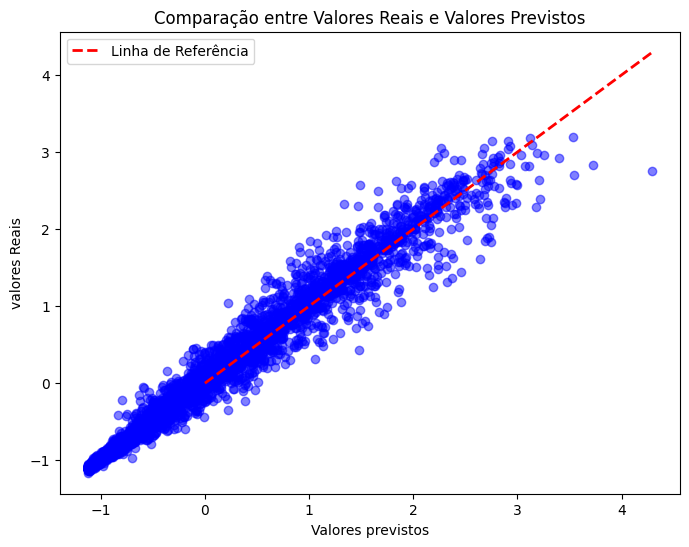

[I 2024-06-30 23:46:00,699] Trial 2 finished with value: 0.03096143901348114 and parameters: {'hidden_dim': 22, 'num_layers': 19, 'learning_rate': 0.00011556415977123615, 'batch_size': 512}. Best is trial 0 with value: 0.02866625413298607.


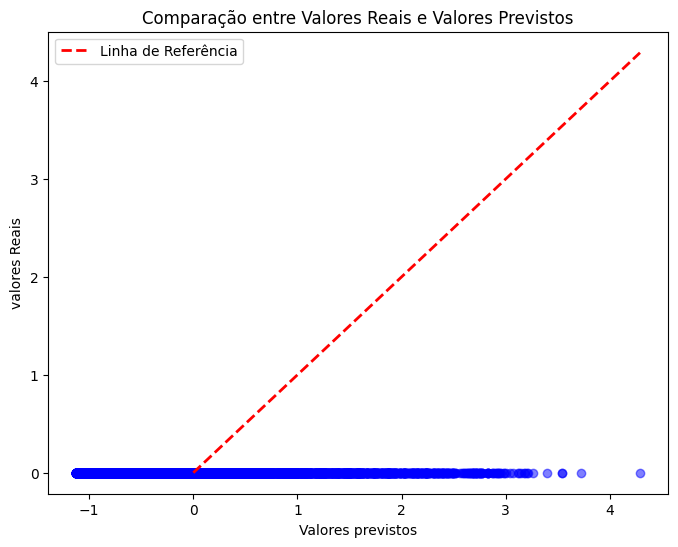

[I 2024-06-30 23:47:24,318] Trial 3 finished with value: 0.991595447063446 and parameters: {'hidden_dim': 21, 'num_layers': 34, 'learning_rate': 0.0001930243731232507, 'batch_size': 512}. Best is trial 0 with value: 0.02866625413298607.


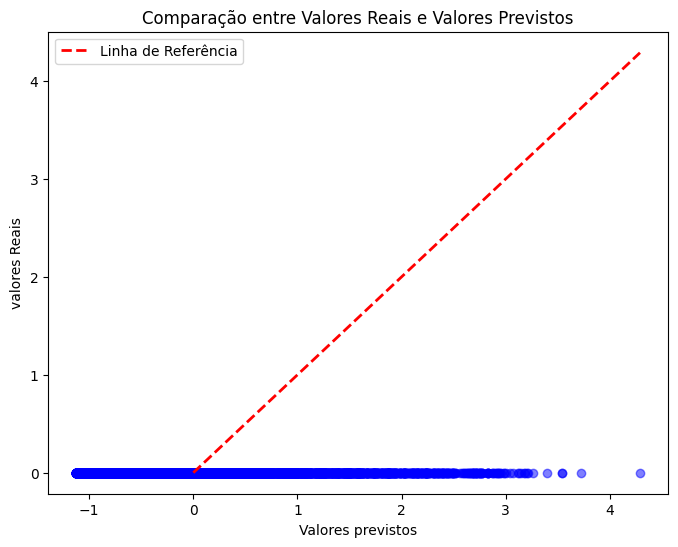

[I 2024-06-30 23:48:47,149] Trial 4 finished with value: 0.9915595054626465 and parameters: {'hidden_dim': 23, 'num_layers': 34, 'learning_rate': 0.00013845917454631583, 'batch_size': 512}. Best is trial 0 with value: 0.02866625413298607.


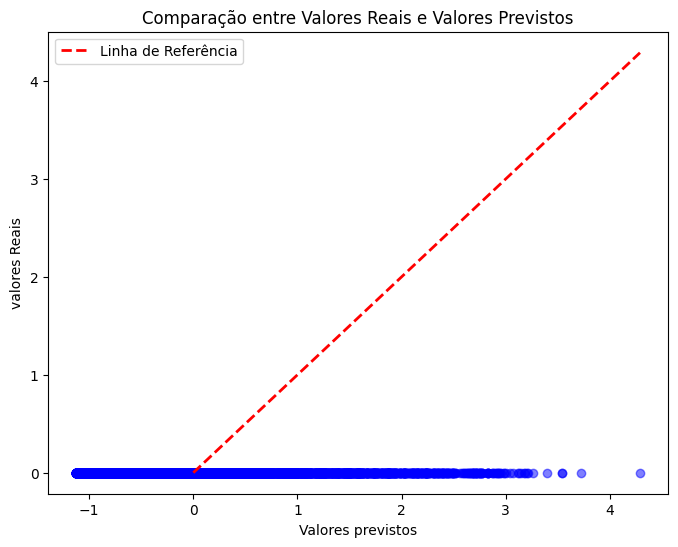

[I 2024-06-30 23:51:09,984] Trial 5 finished with value: 0.9915593266487122 and parameters: {'hidden_dim': 54, 'num_layers': 36, 'learning_rate': 0.00017632505714384425, 'batch_size': 512}. Best is trial 0 with value: 0.02866625413298607.


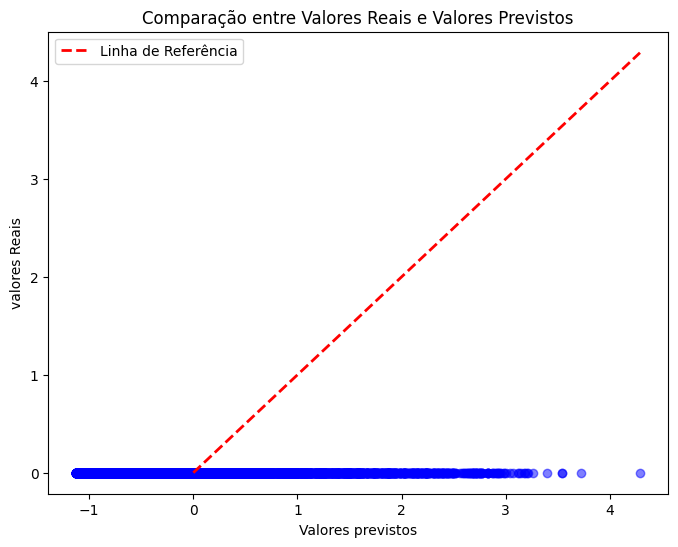

[I 2024-06-30 23:52:37,140] Trial 6 finished with value: 0.9915632009506226 and parameters: {'hidden_dim': 21, 'num_layers': 37, 'learning_rate': 0.00016622328842915812, 'batch_size': 512}. Best is trial 0 with value: 0.02866625413298607.


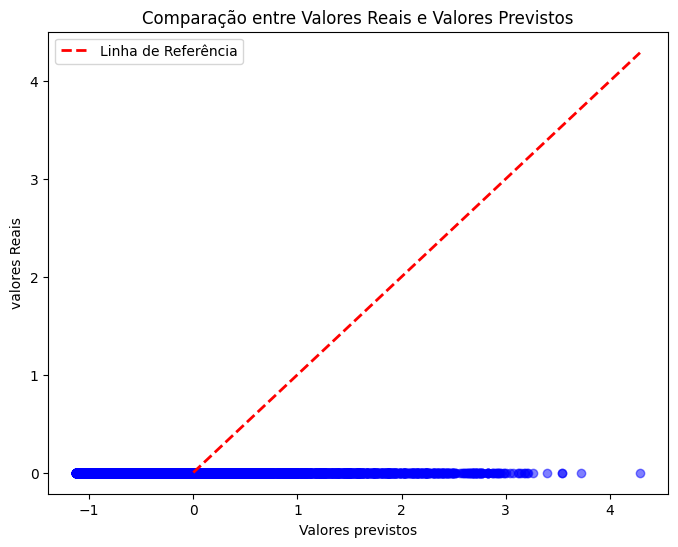

[I 2024-06-30 23:54:43,953] Trial 7 finished with value: 0.9915387630462646 and parameters: {'hidden_dim': 45, 'num_layers': 37, 'learning_rate': 0.00017326197346252459, 'batch_size': 512}. Best is trial 0 with value: 0.02866625413298607.


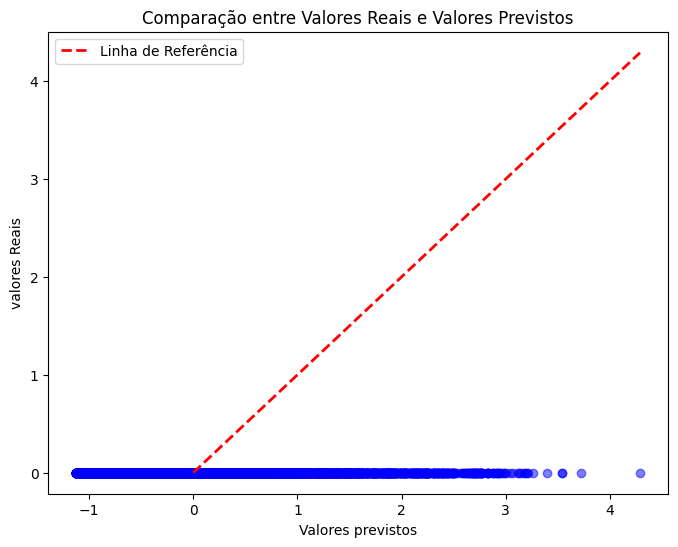

[I 2024-06-30 23:56:50,343] Trial 8 finished with value: 0.9915576577186584 and parameters: {'hidden_dim': 44, 'num_layers': 39, 'learning_rate': 0.0001447500563842135, 'batch_size': 512}. Best is trial 0 with value: 0.02866625413298607.


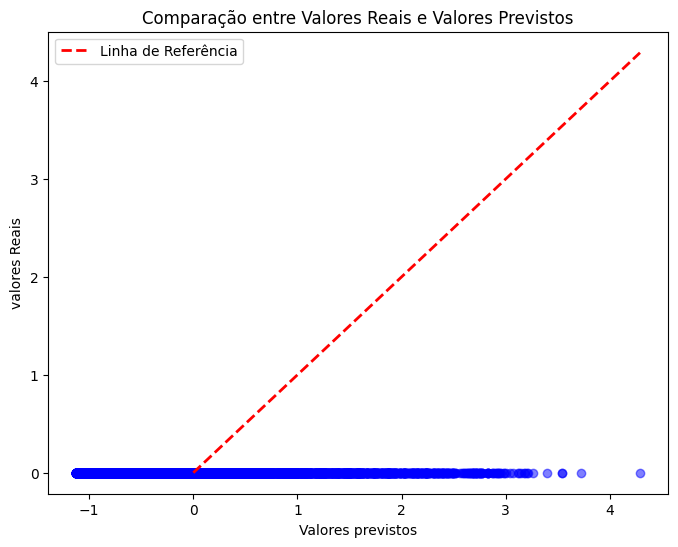

[I 2024-06-30 23:58:48,103] Trial 9 finished with value: 0.9915724396705627 and parameters: {'hidden_dim': 57, 'num_layers': 28, 'learning_rate': 0.0001262992124178125, 'batch_size': 512}. Best is trial 0 with value: 0.02866625413298607.


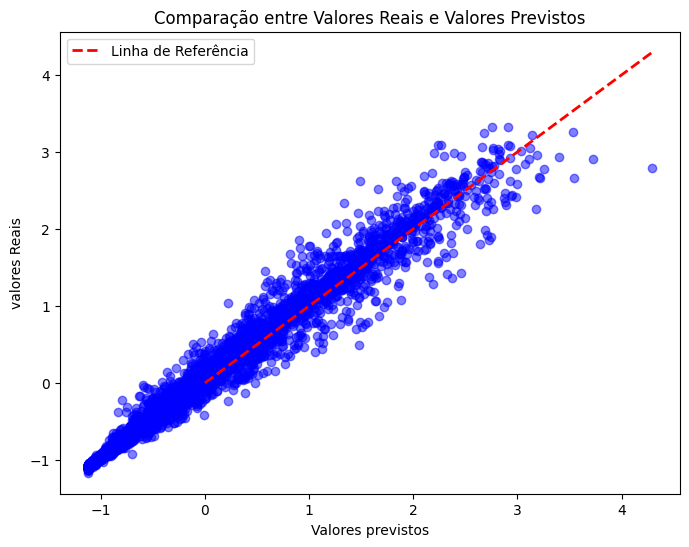

[I 2024-06-30 23:59:41,199] Trial 10 finished with value: 0.031279195100069046 and parameters: {'hidden_dim': 64, 'num_layers': 11, 'learning_rate': 0.0001036734914485413, 'batch_size': 512}. Best is trial 0 with value: 0.02866625413298607.


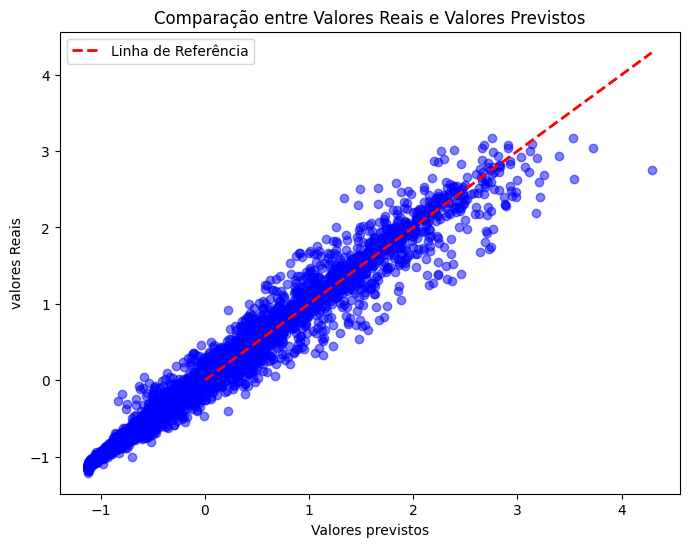

[I 2024-07-01 00:00:24,809] Trial 11 finished with value: 0.029805153608322144 and parameters: {'hidden_dim': 32, 'num_layers': 14, 'learning_rate': 0.00010061483535603075, 'batch_size': 512}. Best is trial 0 with value: 0.02866625413298607.


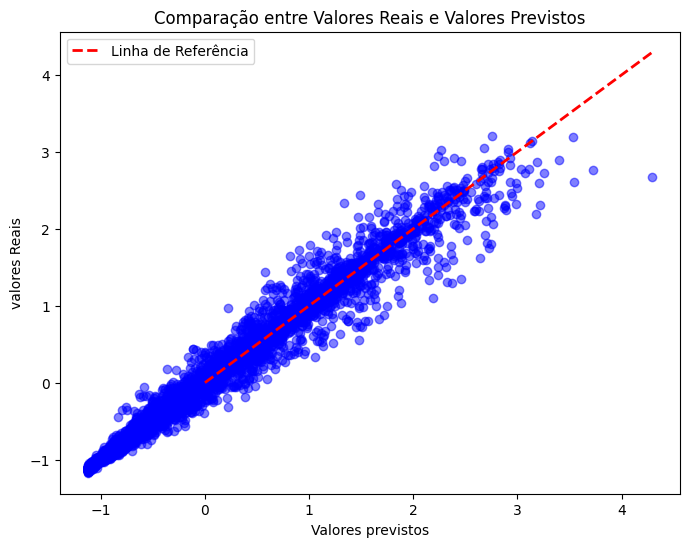

[I 2024-07-01 00:00:58,414] Trial 12 finished with value: 0.029103606939315796 and parameters: {'hidden_dim': 34, 'num_layers': 10, 'learning_rate': 0.00010094866293962108, 'batch_size': 512}. Best is trial 0 with value: 0.02866625413298607.


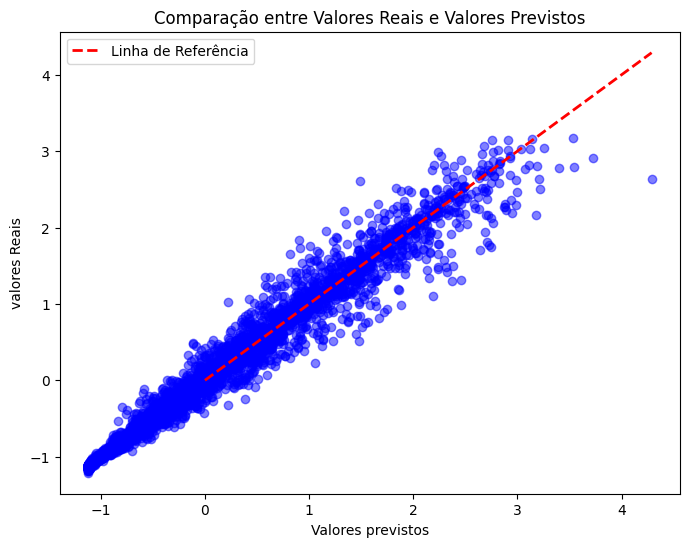

[I 2024-07-01 00:01:53,314] Trial 13 finished with value: 0.028149476274847984 and parameters: {'hidden_dim': 34, 'num_layers': 17, 'learning_rate': 0.0001583913668120336, 'batch_size': 512}. Best is trial 13 with value: 0.028149476274847984.


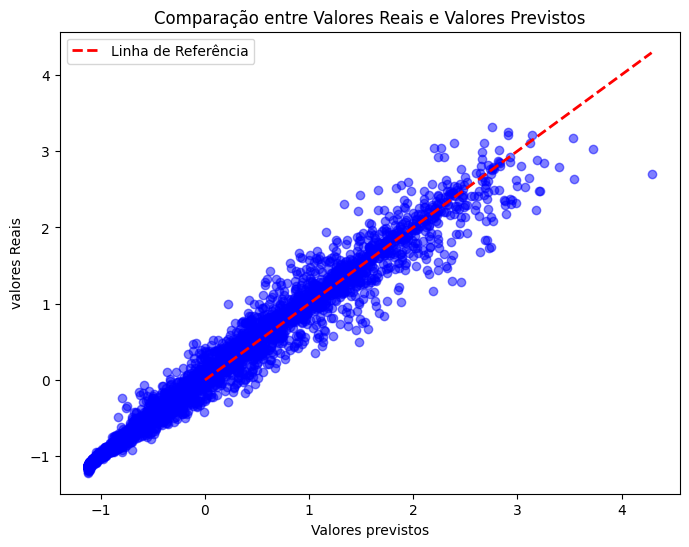

[I 2024-07-01 00:02:56,265] Trial 14 finished with value: 0.028327209874987602 and parameters: {'hidden_dim': 36, 'num_layers': 19, 'learning_rate': 0.00015731261511585593, 'batch_size': 512}. Best is trial 13 with value: 0.028149476274847984.


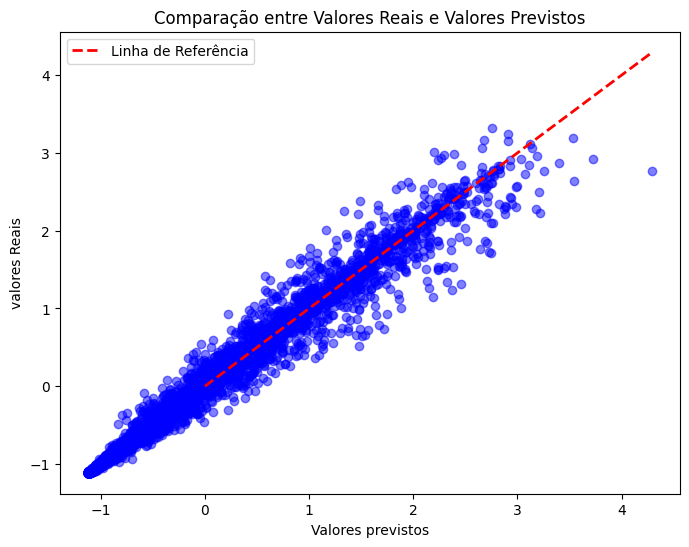

[I 2024-07-01 00:04:09,018] Trial 15 finished with value: 0.028420869261026382 and parameters: {'hidden_dim': 35, 'num_layers': 20, 'learning_rate': 0.0001526140617010005, 'batch_size': 512}. Best is trial 13 with value: 0.028149476274847984.


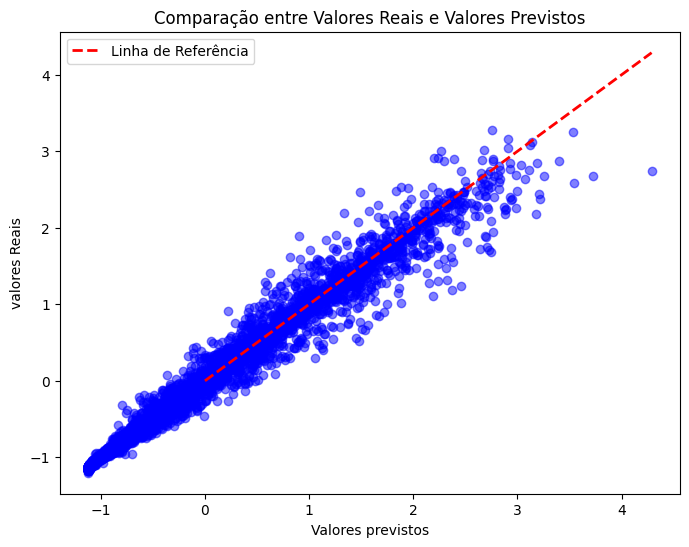

[I 2024-07-01 00:05:07,911] Trial 16 finished with value: 0.028223838657140732 and parameters: {'hidden_dim': 30, 'num_layers': 18, 'learning_rate': 0.00015728689024493747, 'batch_size': 512}. Best is trial 13 with value: 0.028149476274847984.


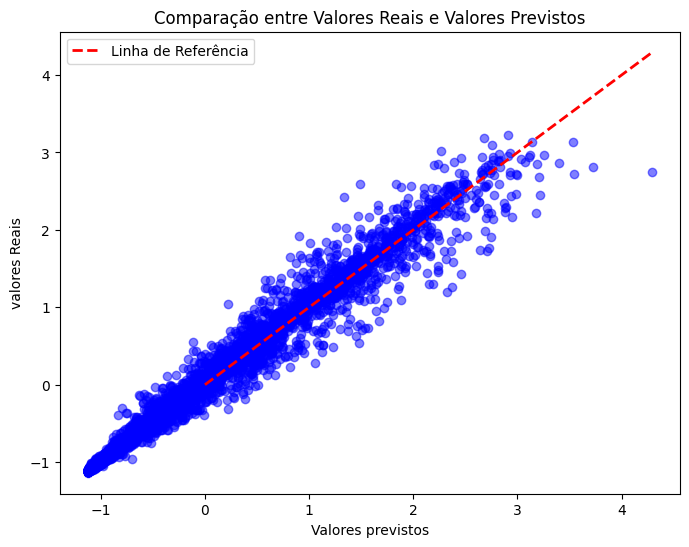

[I 2024-07-01 00:06:21,020] Trial 17 finished with value: 0.029579821974039078 and parameters: {'hidden_dim': 28, 'num_layers': 24, 'learning_rate': 0.00012784444614366274, 'batch_size': 512}. Best is trial 13 with value: 0.028149476274847984.


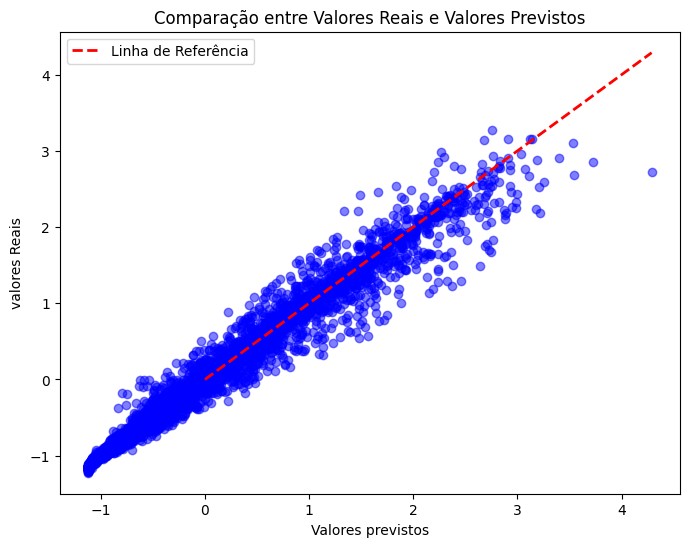

[I 2024-07-01 00:07:07,371] Trial 18 finished with value: 0.031024515628814697 and parameters: {'hidden_dim': 16, 'num_layers': 17, 'learning_rate': 0.0001602547953990271, 'batch_size': 512}. Best is trial 13 with value: 0.028149476274847984.


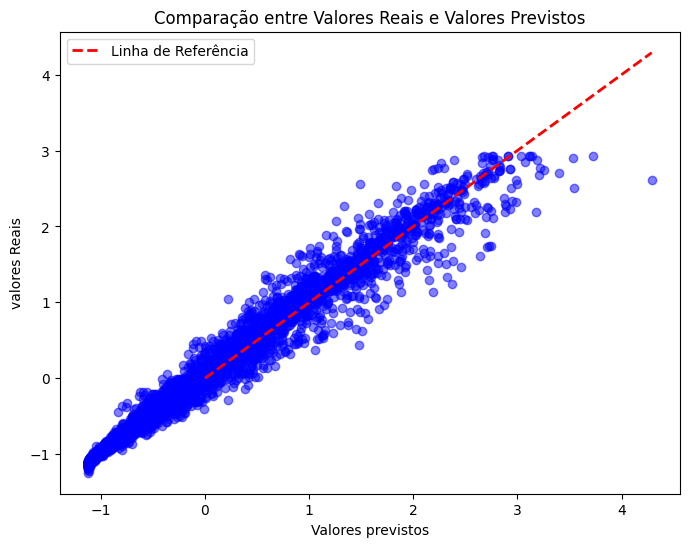

[I 2024-07-01 00:08:16,276] Trial 19 finished with value: 0.02928905561566353 and parameters: {'hidden_dim': 28, 'num_layers': 24, 'learning_rate': 0.00017798643400040705, 'batch_size': 512}. Best is trial 13 with value: 0.028149476274847984.


In [16]:
input_size = X_train_tensor.shape[1]
print(input_size)

study2 = optuna.create_study(direction='minimize')
train_model = create_train_model(input_size,1,X_train_tensor, joule_train_tensor,X_val_tensor,joule_val_tensor)
study2.optimize(train_model, n_trials=20)

trial = study2.best_trial

In [17]:
best_model_j = trial.params

best_model = RegressionModel(X_train_tensor.shape[1], best_model_j['hidden_dim'], 1, best_model_j['num_layers'])
criterion = nn.MSELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_model_j['learning_rate'])

previstos_j = test(best_model,[X_test_tensor,joule_test_tensor])

for name, param in best_model.named_parameters():
    print(f"{name}: {param.size()}")

print(best_model)

MSE Test Loss: 1.0302
MAE Test Loss: 0.8548
MAPE Test Loss: 1.9191
network.0.weight: torch.Size([34, 6])
network.0.bias: torch.Size([34])
network.2.weight: torch.Size([34, 34])
network.2.bias: torch.Size([34])
network.4.weight: torch.Size([34, 34])
network.4.bias: torch.Size([34])
network.6.weight: torch.Size([34, 34])
network.6.bias: torch.Size([34])
network.8.weight: torch.Size([34, 34])
network.8.bias: torch.Size([34])
network.10.weight: torch.Size([34, 34])
network.10.bias: torch.Size([34])
network.12.weight: torch.Size([34, 34])
network.12.bias: torch.Size([34])
network.14.weight: torch.Size([34, 34])
network.14.bias: torch.Size([34])
network.16.weight: torch.Size([34, 34])
network.16.bias: torch.Size([34])
network.18.weight: torch.Size([34, 34])
network.18.bias: torch.Size([34])
network.20.weight: torch.Size([34, 34])
network.20.bias: torch.Size([34])
network.22.weight: torch.Size([34, 34])
network.22.bias: torch.Size([34])
network.24.weight: torch.Size([34, 34])
network.24.bias:

In [18]:
fine_tune(best_model_j, best_model,5000,optimizer,X_train_tensor,joule_train_tensor,X_val_tensor,joule_val_tensor)
previstos_j = test(best_model, [X_test_tensor, joule_test_tensor])
print(previstos_j)

MSE Test Loss: 0.0333
MAE Test Loss: 0.0946
MAPE Test Loss: 1.0315
tensor([[-0.0662],
        [-0.2720],
        [ 0.6734],
        ...,
        [ 1.0718],
        [-0.0562],
        [ 1.8095]])


In [19]:
print('Best trial:')
trial = study2.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

Best trial:
  Value: 0.028149476274847984
  Params: 
    hidden_dim: 34
    num_layers: 17
    learning_rate: 0.0001583913668120336
    batch_size: 512


[I 2024-07-01 00:38:23,874] A new study created in memory with name: no-name-f1678f6a-ef95-4959-856f-1a8aaf0aa3d9


6


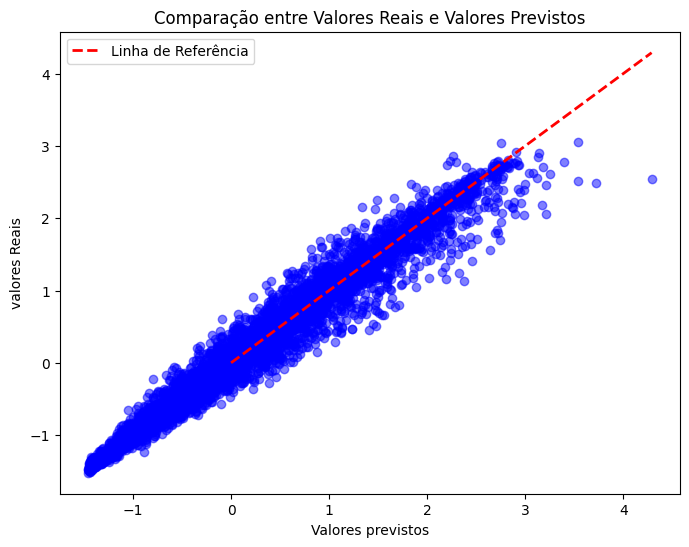

[I 2024-07-01 00:38:57,890] Trial 0 finished with value: 0.025734424591064453 and parameters: {'hidden_dim': 25, 'num_layers': 12, 'learning_rate': 0.00015651814116533544, 'batch_size': 512}. Best is trial 0 with value: 0.025734424591064453.


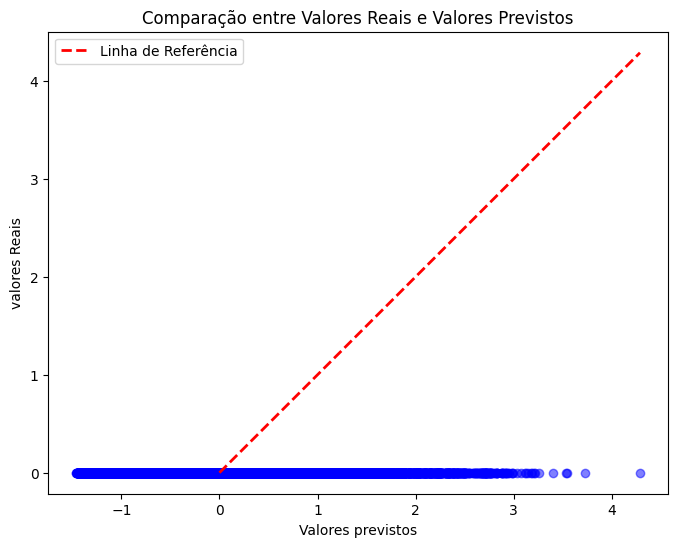

[I 2024-07-01 00:40:46,655] Trial 1 finished with value: 0.9828945398330688 and parameters: {'hidden_dim': 47, 'num_layers': 31, 'learning_rate': 0.00014145605253595942, 'batch_size': 512}. Best is trial 0 with value: 0.025734424591064453.


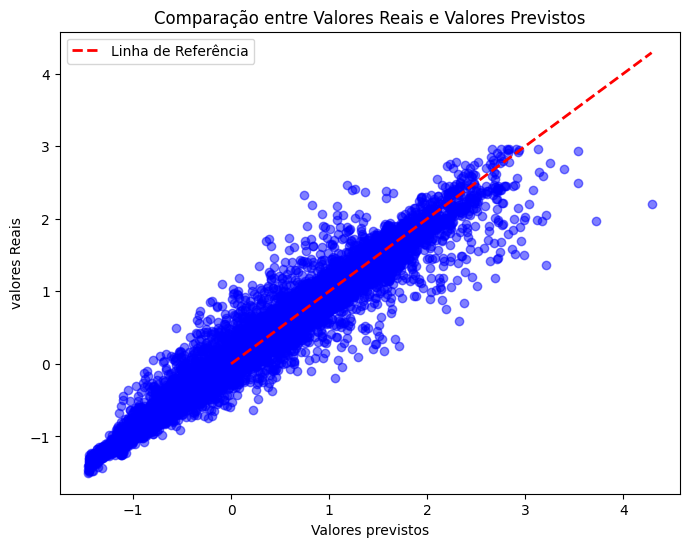

[I 2024-07-01 00:41:58,862] Trial 2 finished with value: 0.05890541896224022 and parameters: {'hidden_dim': 36, 'num_layers': 23, 'learning_rate': 0.0001231920997965696, 'batch_size': 512}. Best is trial 0 with value: 0.025734424591064453.


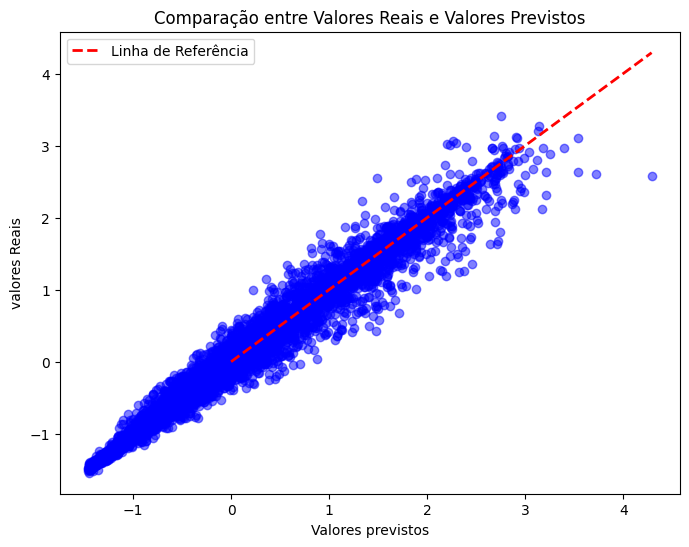

[I 2024-07-01 00:43:13,640] Trial 3 finished with value: 0.023718535900115967 and parameters: {'hidden_dim': 64, 'num_layers': 16, 'learning_rate': 0.0001632190238801106, 'batch_size': 512}. Best is trial 3 with value: 0.023718535900115967.


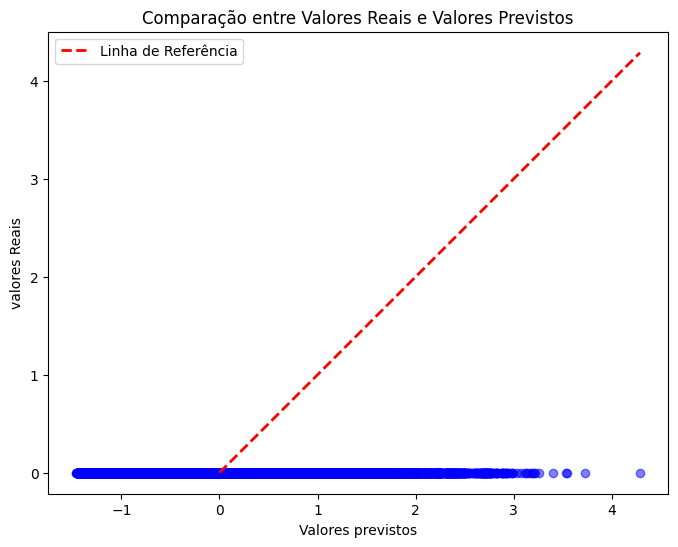

[I 2024-07-01 00:45:40,700] Trial 4 finished with value: 0.9829034805297852 and parameters: {'hidden_dim': 55, 'num_layers': 38, 'learning_rate': 0.00017270902329123862, 'batch_size': 512}. Best is trial 3 with value: 0.023718535900115967.


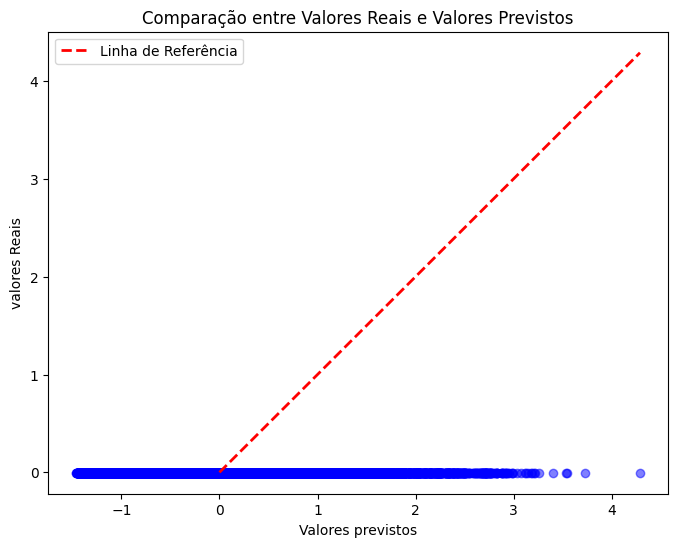

[I 2024-07-01 00:46:45,185] Trial 5 finished with value: 0.9828387498855591 and parameters: {'hidden_dim': 19, 'num_layers': 26, 'learning_rate': 0.00011522480905150895, 'batch_size': 512}. Best is trial 3 with value: 0.023718535900115967.


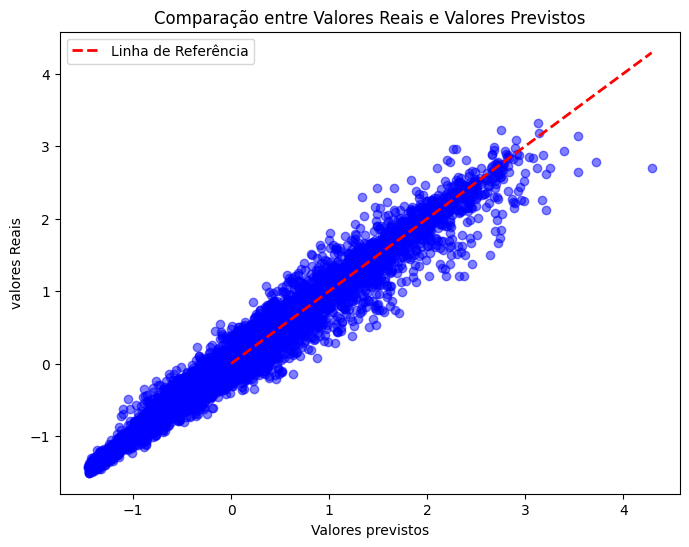

[I 2024-07-01 00:47:17,114] Trial 6 finished with value: 0.026172161102294922 and parameters: {'hidden_dim': 20, 'num_layers': 11, 'learning_rate': 0.00015577454967522473, 'batch_size': 512}. Best is trial 3 with value: 0.023718535900115967.


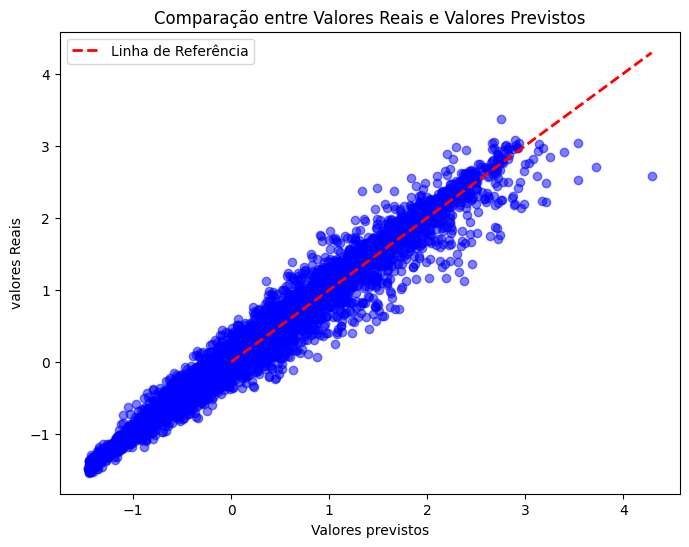

[I 2024-07-01 00:47:57,249] Trial 7 finished with value: 0.025421470403671265 and parameters: {'hidden_dim': 45, 'num_layers': 10, 'learning_rate': 0.00012336795347796763, 'batch_size': 512}. Best is trial 3 with value: 0.023718535900115967.


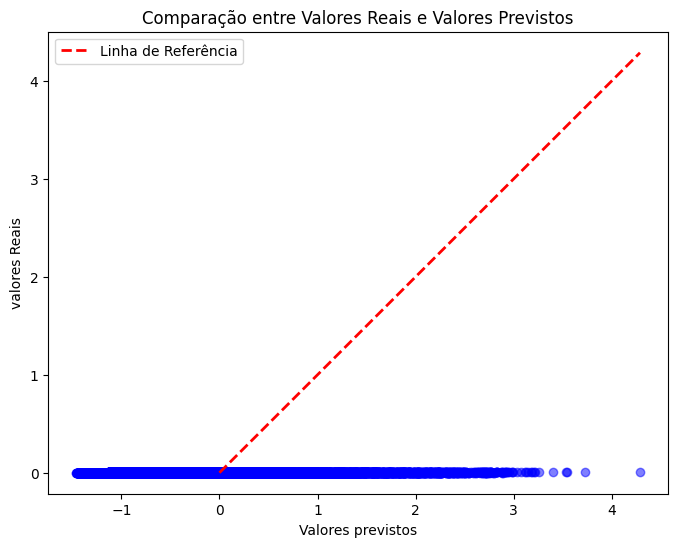

[I 2024-07-01 00:49:48,147] Trial 8 finished with value: 0.9829343557357788 and parameters: {'hidden_dim': 46, 'num_layers': 33, 'learning_rate': 0.00013069337295896471, 'batch_size': 512}. Best is trial 3 with value: 0.023718535900115967.


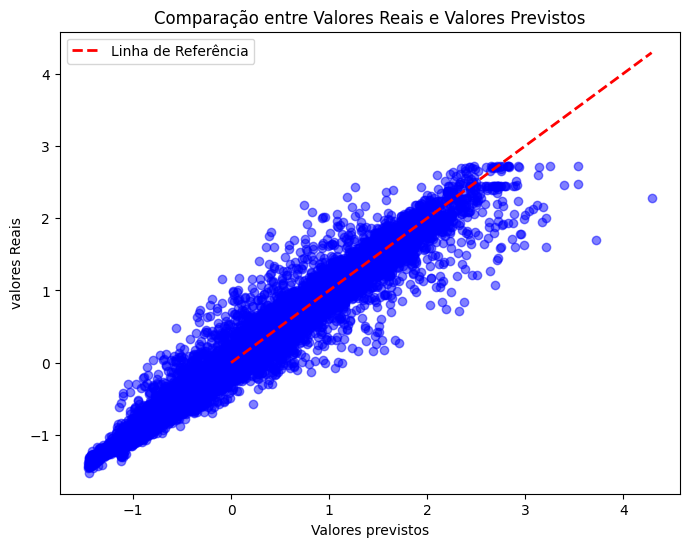

[I 2024-07-01 00:50:45,787] Trial 9 finished with value: 0.059607986360788345 and parameters: {'hidden_dim': 22, 'num_layers': 23, 'learning_rate': 0.00015616869987632008, 'batch_size': 512}. Best is trial 3 with value: 0.023718535900115967.


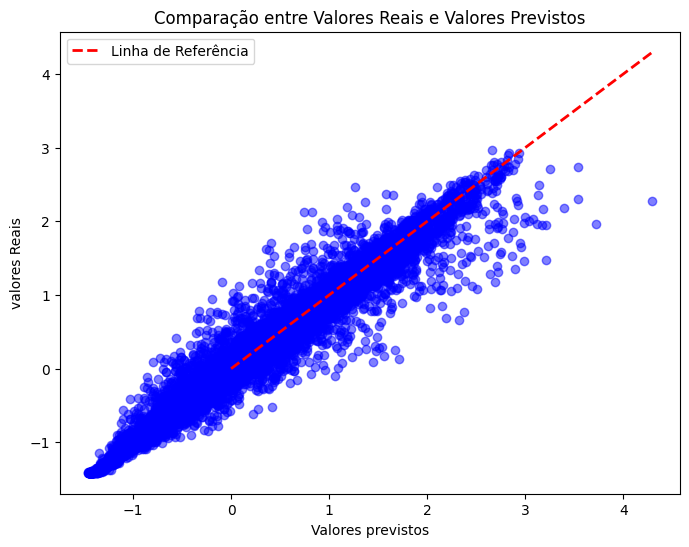

[I 2024-07-01 00:52:20,850] Trial 10 finished with value: 0.05691976845264435 and parameters: {'hidden_dim': 63, 'num_layers': 19, 'learning_rate': 0.00019358574557104424, 'batch_size': 512}. Best is trial 3 with value: 0.023718535900115967.


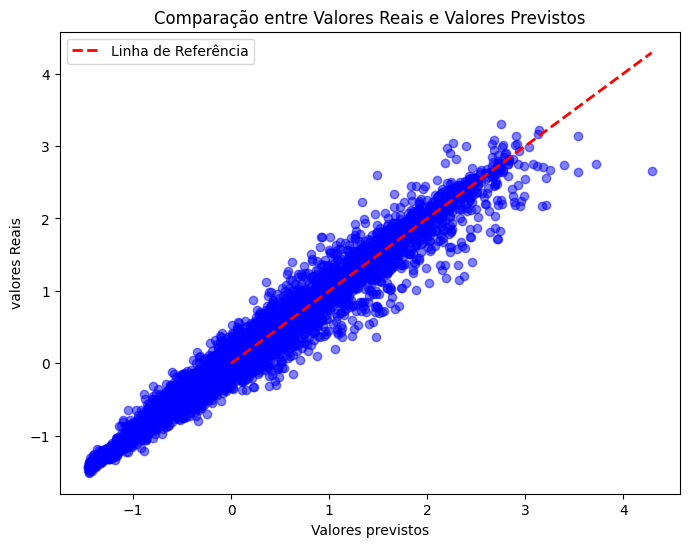

[I 2024-07-01 00:53:35,933] Trial 11 finished with value: 0.024045605212450027 and parameters: {'hidden_dim': 64, 'num_layers': 16, 'learning_rate': 0.00010618489921515779, 'batch_size': 512}. Best is trial 3 with value: 0.023718535900115967.


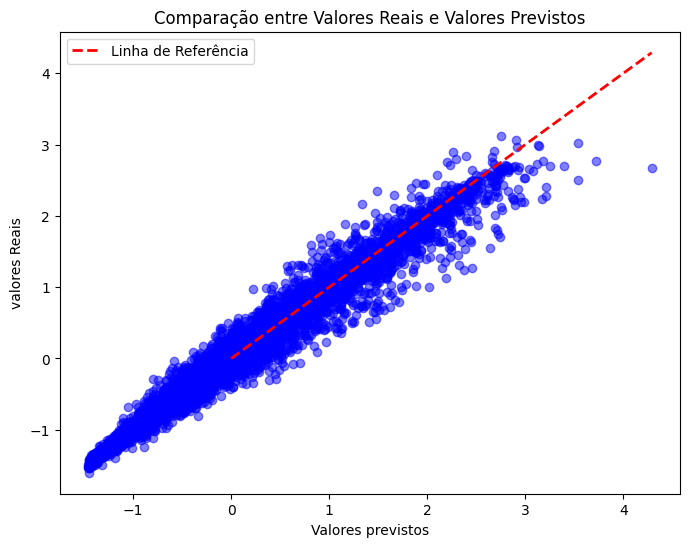

[I 2024-07-01 00:54:49,915] Trial 12 finished with value: 0.024590548127889633 and parameters: {'hidden_dim': 64, 'num_layers': 16, 'learning_rate': 0.00010802930079012864, 'batch_size': 512}. Best is trial 3 with value: 0.023718535900115967.


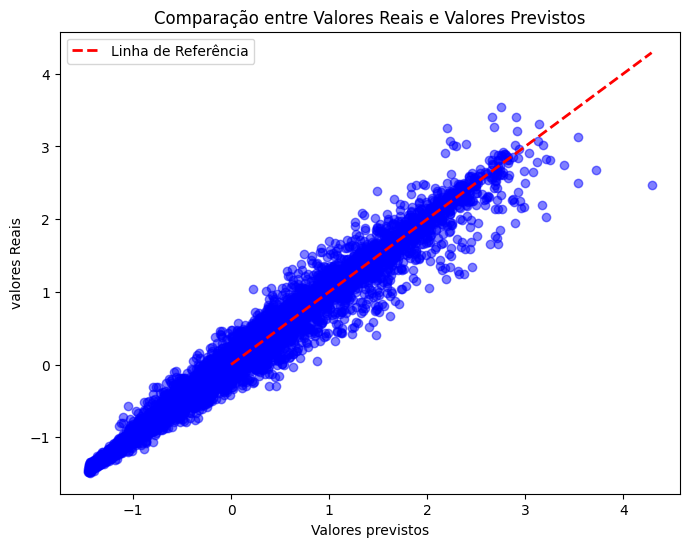

[I 2024-07-01 00:55:59,834] Trial 13 finished with value: 0.02479487471282482 and parameters: {'hidden_dim': 56, 'num_layers': 16, 'learning_rate': 0.00010496201205799523, 'batch_size': 512}. Best is trial 3 with value: 0.023718535900115967.


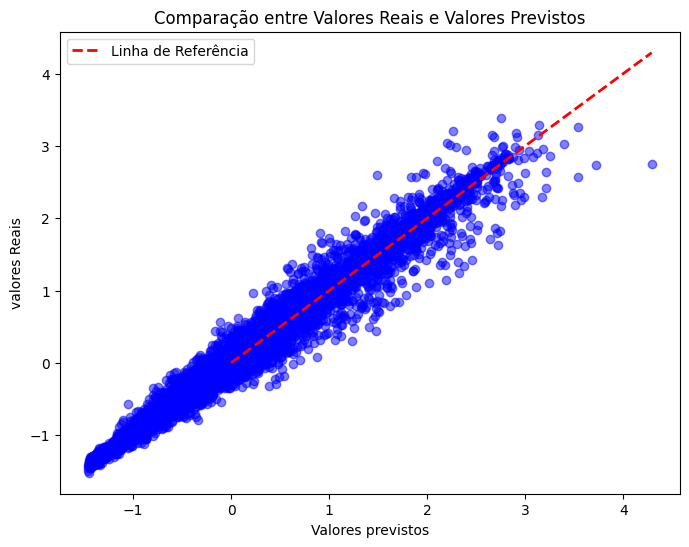

[I 2024-07-01 00:57:19,022] Trial 14 finished with value: 0.024500975385308266 and parameters: {'hidden_dim': 56, 'num_layers': 18, 'learning_rate': 0.0001838266802393959, 'batch_size': 512}. Best is trial 3 with value: 0.023718535900115967.


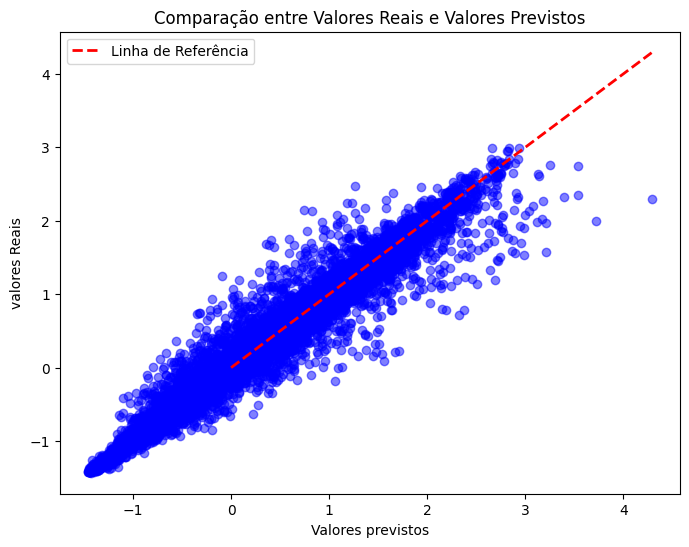

[I 2024-07-01 00:58:14,671] Trial 15 finished with value: 0.05641351640224457 and parameters: {'hidden_dim': 29, 'num_layers': 20, 'learning_rate': 0.0001707179107800436, 'batch_size': 512}. Best is trial 3 with value: 0.023718535900115967.


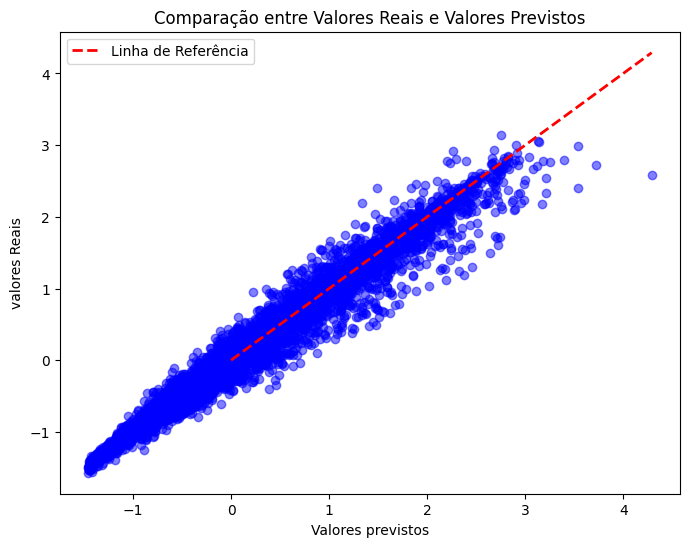

[I 2024-07-01 00:59:22,462] Trial 16 finished with value: 0.02443505823612213 and parameters: {'hidden_dim': 60, 'num_layers': 14, 'learning_rate': 0.0001397949880539756, 'batch_size': 512}. Best is trial 3 with value: 0.023718535900115967.


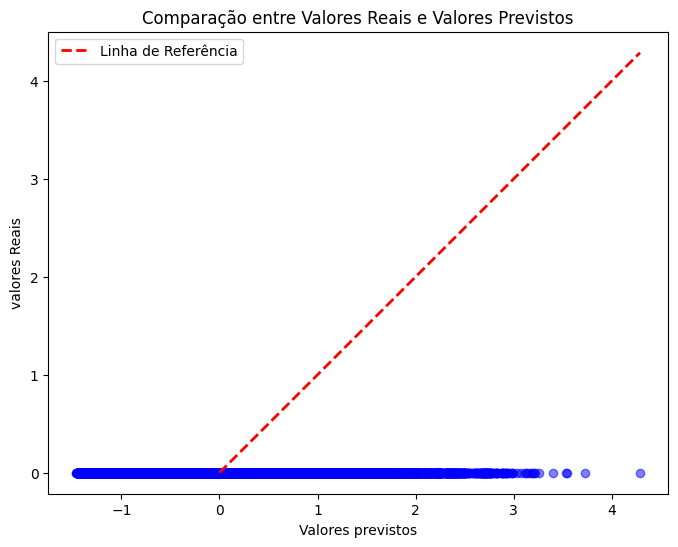

[I 2024-07-01 01:01:01,600] Trial 17 finished with value: 0.9829097986221313 and parameters: {'hidden_dim': 51, 'num_layers': 26, 'learning_rate': 0.00010050369592748005, 'batch_size': 512}. Best is trial 3 with value: 0.023718535900115967.


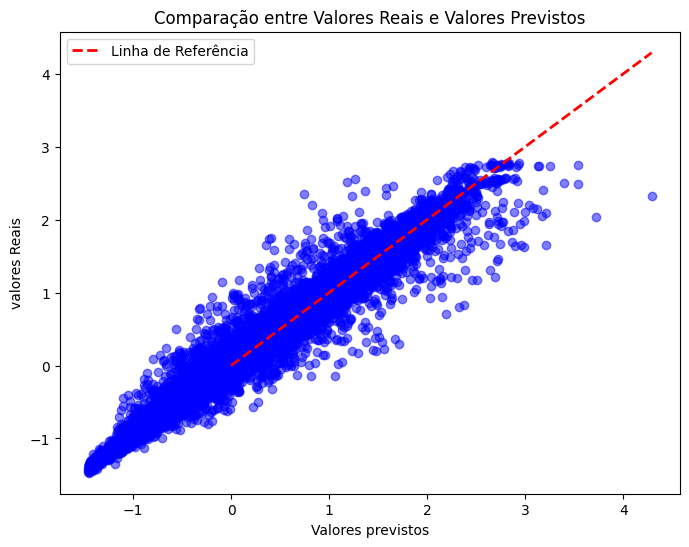

[I 2024-07-01 01:02:07,856] Trial 18 finished with value: 0.057853005826473236 and parameters: {'hidden_dim': 37, 'num_layers': 21, 'learning_rate': 0.00014435167819236368, 'batch_size': 512}. Best is trial 3 with value: 0.023718535900115967.


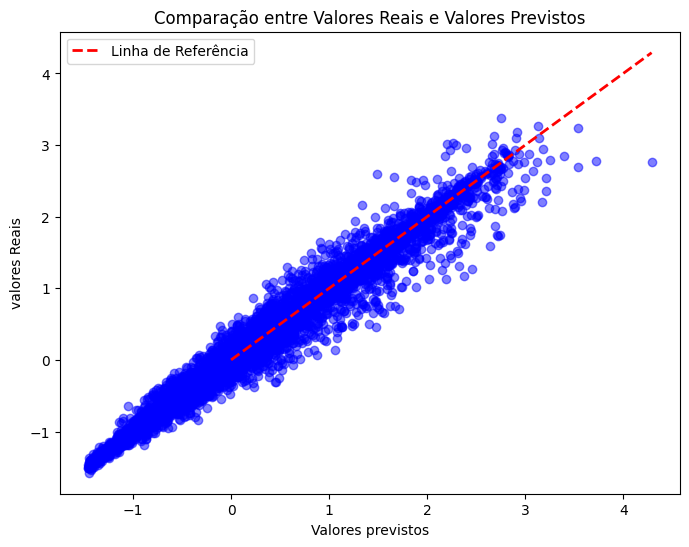

[I 2024-07-01 01:03:14,342] Trial 19 finished with value: 0.023855512961745262 and parameters: {'hidden_dim': 58, 'num_layers': 14, 'learning_rate': 0.00017147557312702816, 'batch_size': 512}. Best is trial 3 with value: 0.023718535900115967.


In [20]:
input_size = X_train_tensor.shape[1]
print(input_size)

study3 = optuna.create_study(direction='minimize')
train_model = create_train_model(input_size,2,X_train_tensor, y_train_tensor,X_val_tensor,y_val_tensor)
study3.optimize(train_model, n_trials=20)

trial = study3.best_trial

In [21]:
best_model_t = trial.params

best_model = RegressionModel(X_train_tensor.shape[1], best_model_t['hidden_dim'], 2, best_model_t['num_layers'])
criterion = nn.MSELoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_model_t['learning_rate'])

previstos_t = test(best_model,[X_test_tensor,y_test_tensor])

for name, param in best_model.named_parameters():
    print(f"{name}: {param.size()}")

print(best_model)

MSE Test Loss: 1.0176
MAE Test Loss: 0.8331
MAPE Test Loss: 1.0977
network.0.weight: torch.Size([64, 6])
network.0.bias: torch.Size([64])
network.2.weight: torch.Size([64, 64])
network.2.bias: torch.Size([64])
network.4.weight: torch.Size([64, 64])
network.4.bias: torch.Size([64])
network.6.weight: torch.Size([64, 64])
network.6.bias: torch.Size([64])
network.8.weight: torch.Size([64, 64])
network.8.bias: torch.Size([64])
network.10.weight: torch.Size([64, 64])
network.10.bias: torch.Size([64])
network.12.weight: torch.Size([64, 64])
network.12.bias: torch.Size([64])
network.14.weight: torch.Size([64, 64])
network.14.bias: torch.Size([64])
network.16.weight: torch.Size([64, 64])
network.16.bias: torch.Size([64])
network.18.weight: torch.Size([64, 64])
network.18.bias: torch.Size([64])
network.20.weight: torch.Size([64, 64])
network.20.bias: torch.Size([64])
network.22.weight: torch.Size([64, 64])
network.22.bias: torch.Size([64])
network.24.weight: torch.Size([64, 64])
network.24.bias:

In [22]:
fine_tune(best_model_t,best_model,5000,optimizer,X_train_tensor,y_train_tensor,X_val_tensor,y_val_tensor)
previstos_t = test(best_model, [X_test_tensor, y_test_tensor])
print(previstos_t)

MSE Test Loss: 0.0365
MAE Test Loss: 0.1008
MAPE Test Loss: 0.7596
tensor([[ 0.4090, -0.0744],
        [ 0.1423, -0.2535],
        [ 1.1237,  0.6676],
        ...,
        [ 1.2150,  0.9879],
        [-0.0988,  0.0070],
        [ 2.1687,  1.9337]])


In [23]:
print('Best trial:')
trial = study3.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

Best trial:
  Value: 0.023718535900115967
  Params: 
    hidden_dim: 64
    num_layers: 16
    learning_rate: 0.0001632190238801106
    batch_size: 512


In [24]:
mse_h = mean_squared_error(histeresis_test_tensor, previstos_h)
mae_h = mean_absolute_error(histeresis_test_tensor, previstos_h)
histeresis_test_np = histeresis_test_tensor.numpy()
previstos_np_h = previstos_h.numpy()
mape_h = np.mean(np.abs((histeresis_test_np - previstos_np_h) / histeresis_test_np)) * 100

mse_j = mean_squared_error(joule_test_tensor, previstos_j)
mae_j = mean_absolute_error(joule_test_tensor, previstos_j)
joule_test_np = joule_test_tensor.numpy()
previstos_np_j = previstos_j.numpy()
mape_j = np.mean(np.abs((joule_test_np - previstos_np_j) / joule_test_np)) * 100

mse_t = mean_squared_error(y_test_tensor, previstos_t)
mae_t = mean_absolute_error(y_test_tensor, previstos_t)
total_test_np = y_test_tensor.numpy()
previstos_np_t = previstos_t.numpy()
mape_t = np.mean(np.abs((total_test_np - previstos_np_t) / total_test_np)) * 100

print(f'V histeresis model:')
print(f'Test MSE: {mse_h}')
print(f'Test MAE: {mae_h}')
print(f'Test MAPE: {mape_h}%')

print(f'V joule model:')
print(f'Test MSE: {mse_j}')
print(f'Test MAE: {mae_j}')
print(f'Test MAPE: {mape_j}%')

print(f'V total model:')
print(f'Test MSE: {mse_t}')
print(f'Test MAE: {mae_t}')
print(f'Test MAPE: {mape_t}%')

V histeresis model:
Test MSE: 0.027832407504320145
Test MAE: 0.09542842209339142
Test MAPE: 64.26418423652649%
V joule model:
Test MSE: 0.033298272639513016
Test MAE: 0.09458539634943008
Test MAPE: 103.1510591506958%
V total model:
Test MSE: 0.036466144025325775
Test MAE: 0.10079623013734818
Test MAPE: 75.96194744110107%


MOTOR: V TARGET: hysteresis
Test MSE: 0.0023566479055486924
Test MAE: 0.0327146871090447
Test MAPE: 31.38279694587414%

MOTOR: V TARGET: joule
Test MSE: 0.003373055334037841
Test MAE: 0.03518469037839705
Test MAPE: 29.203365365204526%

MOTOR: V TARGET: total
Test MSE: 0.009457401765956296
Test MAE: 0.062074677843903185
Test MAPE: 13.852825812435348%